In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras.optimizers import Adam
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import RandomSearch

In [ ]:
# 구글 드라이브 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


이미지 모두 있는지 확인하기

In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/관세청/final_image'
file_list = os.listdir(folder_path)

이미지 확장자 종류 출력

In [ ]:
# 확장자를 저장할 집합
extensions = set()

In [ ]:
# 파일 확장자 추출
for file in file_list:
    _, ext = os.path.splitext(file)
    if ext:  # 확장자가 있는 경우
        extensions.add(ext.lower())

In [ ]:
# 확장자 출력
print("폴더 내의 이미지 파일 확장자:")
for ext in extensions:
    print(ext)

폴더 내의 이미지 파일 확장자:
.jpg
.png


.jpg, .png인 것을 확인할 수 있음.

In [ ]:
# 다양한 확장자를 고려한 함수
def file_exists(file_number):
    extensions = ['png', 'jpg', 'JPG', 'PNG']
    for ext in extensions:
        if f"{file_number}.{ext}" in file_list:
            return True
    return False

In [ ]:
# 2부터 17667까지의 파일 번호에 대해 존재 여부 확인
expected_files = range(2, 17668)
missing_files = [f"{file_number}.png" for file_number in expected_files if not file_exists(file_number)]

if not missing_files:
    print("All files from 2.png to 17667.png are present.")
else:
    print(f"Missing files: {missing_files}")

All files from 2.png to 17667.png are present.


=> 2부터 17667까지의 이미지 파일이 정상적으로 있음.

엑셀 파일 불러오기

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/관세청/updated_final_dataset.xlsx'
df = pd.read_excel(file_path)

In [ ]:
df.head()

,Name,Image URL,label
0,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
1,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
2,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
3,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
4,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204


In [ ]:
df.tail()

,Name,Image URL,label
17661,NaN,NaN,6102
17662,NaN,NaN,6102
17663,NaN,NaN,6102
17664,NaN,NaN,6102
17665,NaN,NaN,6102


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17666 entries, 0 to 17665
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       11954 non-null  object
 1   Image URL  11954 non-null  object
 2   label      17666 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 414.2+ KB


index 수정하기

In [ ]:
# 인덱스 변경
df.index = range(2, 17668)
df

,Name,Image URL,label
2,Elite 스트레이트 진 | 7 For All Mankind,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
3,로우라이즈 부츠컷 진 | Saint Laurent,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
4,Marlo 스트레이트 진 | Tove,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
5,Nedar 하이라이즈 스트레이트 진 | Loro Piana,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
6,스트레이트 진 | Toteme,https://img.mytheresa.com/652/738/100/jpeg/cat...,6204
...,...,...,...
17663,NaN,NaN,6102
17664,NaN,NaN,6102
17665,NaN,NaN,6102
17666,NaN,NaN,6102


=> 정상적으로 인덱스 변경

이미지 데이터 전처리

In [ ]:
# 이미지 데이터 불러오기 및 전처리
image_size = (128, 128)  # 이미지 크기 조정
images = []
labels = []

In [ ]:
# 다양한 확장자를 고려한 함수
def find_image_path(idx, folder_path):
    extensions = ['png', 'jpg', 'JPG', 'PNG']
    for ext in extensions:
        img_path = os.path.join(folder_path, f'{idx}.{ext}')
        if os.path.exists(img_path):
            return img_path
    return None

In [ ]:
# 이미지 데이터 불러오기 및 전처리
for idx in df.index:
    img_path = find_image_path(idx, folder_path)
    if img_path:
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(df.loc[idx, 'label'])  # df의 'label' 컬럼 사용

In [ ]:
# 이미지와 레이블의 수를 확인
print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

Total images loaded: 17666
Total labels loaded: 17666


원핫 인코딩

In [ ]:
# 이미지를 numpy 배열로 변환
X = np.array(images)
y = np.array(labels)

In [ ]:
# 데이터 정규화
X = X / 255.0

In [ ]:
df['label'].unique()

array([6204, 6104, 6206, 6203, 6110, 6109, 6105, 6101, 6103, 6102, 6205,
       6201, 6106, 6202])

=> 총 14개의 라벨

In [ ]:
# OneHotEncoder 객체 생성
ohe = OneHotEncoder(sparse=False)

# 원-핫 인코딩 적용
y = ohe.fit_transform(df[['label']])

# 인코딩된 결과 확인
y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
# 원래의 클래스 순서 확인
original_classes = ohe.categories_[0]
print("Original classes:", original_classes)

Original classes: [6101 6102 6103 6104 6105 6106 6109 6110 6201 6202 6203 6204 6205 6206]


In [ ]:
for i, label in enumerate(original_classes):
    encoded_vector = y[df['label'] == label][0]
    print(f"Original label: {label}, Encoded vector: {encoded_vector}")

Original label: 6101, Encoded vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6102, Encoded vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6103, Encoded vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6104, Encoded vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6105, Encoded vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6106, Encoded vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6109, Encoded vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: 6110, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original label: 6201, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: 6202, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Original label: 6203, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original label: 6204, Encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: 

In [ ]:
# train, valid, test 데이터 분리(7:2:1 비율)
from sklearn.model_selection import train_test_split

# 전체 데이터 중 70%를 train, 나머지 30%를 temp로 나눔
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# temp 데이터 중 2/3는 validation, 1/3는 test로 나눔
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# 데이터 비율 확인
print(f'Train data: {len(X_train)}')
print(f'Validation data: {len(X_valid)}')
print(f'Test data: {len(X_test)}')

Train data: 12366
Validation data: 3551
Test data: 1749


vgg19

In [ ]:
# 가능한 확장자 목록
extensions = ['.png', '.jpg', '.PNG']

In [ ]:
# 유효한 파일명 찾기 함수
def find_valid_filename(index):
    for ext in extensions:
        file_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/관세청/final_image', str(index) + ext)
        if os.path.exists(file_path):
            return str(index) + ext
    return None

In [ ]:
# 데이터프레임에 유효한 이미지 파일 이름 컬럼 추가
df['filename'] = df.index.map(find_valid_filename)

# 'label' 컬럼 값을 문자열로 변환
df['label'] = df['label'].astype(str)

# 데이터 분할 (7:2:1 비율)
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.33, stratify=df_temp['label'], random_state=42)

# ImageDataGenerator 설정
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# 학습 데이터 제너레이터
train_generator = datagen.flow_from_dataframe(
    df_train,
    directory='/content/drive/MyDrive/Colab Notebooks/관세청/final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 12366 validated image filenames belonging to 14 classes.


In [ ]:
# 검증 데이터 제너레이터
validation_generator = datagen.flow_from_dataframe(
    df_valid,
    directory='/content/drive/MyDrive/Colab Notebooks/관세청/final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3551 validated image filenames belonging to 14 classes.


In [ ]:
# 테스트 데이터 제너레이터
test_generator = datagen.flow_from_dataframe(
    df_test,
    directory='/content/drive/MyDrive/Colab Notebooks/관세청/final_image',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1749 validated image filenames belonging to 14 classes.


In [ ]:
# VGG19 모델 불러오기 (사전 훈련된 가중치 사용)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# 모델 구조 정의
num_classes = len(train_generator.class_indices)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# 기존 층을 학습되지 않도록 고정
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
386/386 [==============================] - 234s 581ms/step - loss: 4.2192 - accuracy: 0.2125 - val_loss: 1.7097 - val_accuracy: 0.4452
Epoch 2/100
386/386 [==============================] - 225s 583ms/step - loss: 2.0471 - accuracy: 0.3848 - val_loss: 1.4382 - val_accuracy: 0.5469
Epoch 3/100
386/386 [==============================] - 226s 585ms/step - loss: 1.6882 - accuracy: 0.4716 - val_loss: 1.2748 - val_accuracy: 0.5940
Epoch 4/100
386/386 [==============================] - 222s 575ms/step - loss: 1.4900 - accuracy: 0.5309 - val_loss: 1.1622 - val_accuracy: 0.6313
Epoch 5/100
386/386 [==============================] - 221s 572ms/step - loss: 1.3531 - accuracy: 0.5721 - val_loss: 1.0784 - val_accuracy: 0.6534
Epoch 6/100
386/386 [==============================] - 223s 577ms/step - loss: 1.2522 - accuracy: 0.5966 - val_loss: 1.0240 - val_accuracy: 0.6753
Epoch 7/100
386/386 [==============================] - 225s 583ms/step - loss: 1.1605 - accuracy: 0.6280 - val_loss: 0

In [ ]:
# 모델 평가 함수 정의
def model_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(f1))
    print(classification_report(y_test, y_pred))

In [ ]:
# 테스트 데이터에 대해 예측
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

55/55 [==============================] - 30s 550ms/step


In [ ]:
# 실제 라벨 가져오기
y_test_classes = test_generator.classes

In [ ]:
# 모델 평가 함수 호출
model_eval(y_test_classes, pred_classes)

오차행렬:
 [[ 71   4   0   1   6   1   0   2  11   1   1   0   0   1]
 [  0  83   0   4   0   0   0   3   0   6   0   1   2   0]
 [  2   0  60   1   1   0   0   2   5   0  28   0   0   0]
 [  0   4   0  80   0   1   0   4   0   1   0   8   0   1]
 [  7   1   1   1  59  10   2   2   0   0   0   0   9   7]
 [  3   3   0   2   1  82   4   2   0   0   0   0   1   1]
 [  0   1   0   1   0   1 140  14   0   0   0   1   3   0]
 [  3   0   0   3   0   1  10 190   2   3   3   3   0   9]
 [  2   0   0   0   1   0   0   3  77   0  11   0   5   0]
 [  3   1   1   2   0   0   0   4   4  80   0   1   0   3]
 [  0   0  28   0   1   0   0   3   2   2 150   1   5   1]
 [  0   0   2   5   0   0   0   2   0   2   0 143   0   3]
 [  0   1   0   0   4   4   3   3   1   0   7   0  74   2]
 [  0   0   0   0   0   1   2  10   0   1   2   3   0 101]]

정확도: 0.7947
정밀도: 0.7947
재현율: 0.7947
F1: 0.7934
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        99
         

학습곡선 그리기

In [ ]:
# 학습 곡선 그리기
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

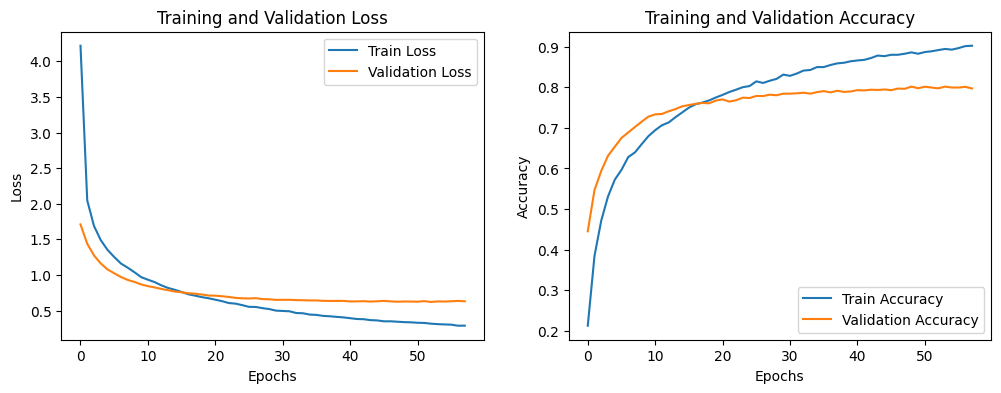

In [ ]:
# 학습 곡선 출력
plot_learning_curve(history)

하이퍼파라미터 튜닝

In [ ]:
def model_builder(hp):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='vgg19_tuning',
    project_name='vgg19_tuning_project'
)

In [ ]:
# 튜너 검색 수행
tuner.search(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping])

In [ ]:
# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
최적의 하이퍼파라미터:
- Dense 레이어 유닛 수: {best_hps.get('units')}
- Dropout 비율: {best_hps.get('dropout')}
- 학습률: {best_hps.get('learning_rate')}
""")


최적의 하이퍼파라미터:
- Dense 레이어 유닛 수: 512
- Dropout 비율: 0.1
- 학습률: 0.00026421929875193183



In [ ]:
# 최적의 하이퍼파라미터로 모델 빌드
model = tuner.hypermodel.build(best_hps)

In [ ]:
# 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
386/386 [==============================] - 230s 592ms/step - loss: 1.6184 - accuracy: 0.5489 - val_loss: 0.9633 - val_accuracy: 0.6832
Epoch 2/100
386/386 [==============================] - 224s 581ms/step - loss: 0.8794 - accuracy: 0.7149 - val_loss: 0.8305 - val_accuracy: 0.7241
Epoch 3/100
386/386 [==============================] - 228s 590ms/step - loss: 0.6667 - accuracy: 0.7818 - val_loss: 0.7413 - val_accuracy: 0.7659
Epoch 4/100
386/386 [==============================] - 224s 579ms/step - loss: 0.5493 - accuracy: 0.8177 - val_loss: 0.6966 - val_accuracy: 0.7747
Epoch 5/100
386/386 [==============================] - 221s 573ms/step - loss: 0.4547 - accuracy: 0.8503 - val_loss: 0.6804 - val_accuracy: 0.7770
Epoch 6/100
386/386 [==============================] - 222s 576ms/step - loss: 0.3935 - accuracy: 0.8687 - val_loss: 0.6681 - val_accuracy: 0.7855
Epoch 7/100
386/386 [==============================] - 219s 568ms/step - loss: 0.3393 - accuracy: 0.8871 - val_loss: 0

In [ ]:
# 테스트 데이터에 대해 예측
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

55/55 [==============================] - 26s 463ms/step


In [ ]:
# 실제 라벨 가져오기
y_test_classes = test_generator.classes

In [ ]:
# 모델 평가 함수 호출
model_eval(y_test_classes, pred_classes)

오차행렬:
 [[ 60   3   2   2  12   2   0   3   9   3   2   0   0   1]
 [  2  69   1   5   0   1   0   3   2  14   0   0   0   2]
 [  1   0  52   0   1   0   0   1   5   0  38   0   0   1]
 [  2   1   0  78   1   1   0   3   0   3   0  10   0   0]
 [  4   1   0   1  62  12   2   5   2   0   0   0   6   4]
 [  2   1   0   2   3  78   4   4   0   0   0   1   1   3]
 [  0   0   0   1   0   0 143  11   1   0   0   0   4   1]
 [  1   0   2   5   0   4  13 179   1   6   4   2   0  10]
 [  1   0   2   0   1   0   0   1  80   0  13   0   1   0]
 [  1   1   1   2   0   1   0   3   4  81   0   1   0   4]
 [  0   0  20   0   0   0   0   1   3   1 163   1   3   1]
 [  0   0   0   4   0   0   0   5   0   1   2 144   0   1]
 [  0   0   0   0   3   1   3   1   3   1   8   0  77   2]
 [  0   0   0   0   0   1   4   7   0   3   2   2   1 100]]

정확도: 0.7810
정밀도: 0.7837
재현율: 0.7810
F1: 0.7788
              precision    recall  f1-score   support

           0       0.81      0.61      0.69        99
         

- 하이퍼파라미터 튜닝 전 : 0.7947(정확도), 0.7947(정밀도), 0.7947(재현율), 0.7934(f1-score)
- 하이퍼파라미터 튜닝 후 : 0.7810(정확도), 0.7837(정밀도), 0.7810(재현율), 0.7788(f1-score)
- 하이퍼파라미터 튜닝 전이 낫다

학습곡선 그리기

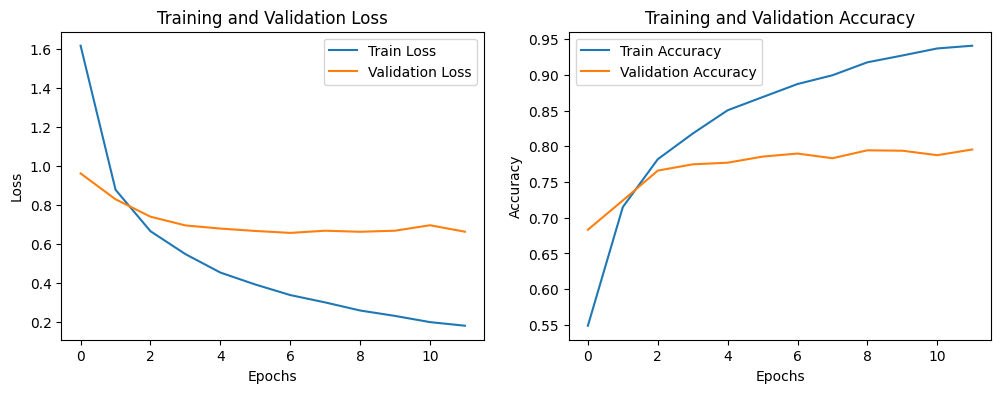

In [ ]:
# 학습 곡선 출력
plot_learning_curve(history)